In [28]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras import models
from sklearn.metrics import classification_report,confusion_matrix

**Dataset Download Link**
[https://drive.google.com/file/d/1ULKLK_R0qsLho6PzfUIOwTXOStk3w5jd/view?usp=sharing](https://drive.google.com/file/d/1ULKLK_R0qsLho6PzfUIOwTXOStk3w5jd/view?usp=sharing)

In [29]:
directory_found=False
my_data_dir='/content/drive/MyDrive/Colab Notebooks/cell_images'

while not os.path.exists(my_data_dir):
  print("The files are not found in the directory!\nTrying to get permission to access Drive.")
  from google.colab import drive
  drive.mount('/content/drive')
  option=input("Do you want to load using the default directory [y/n]:")
  if option.lower() == 'y':
    my_data_dir = '/content/drive/MyDrive/Colab Notebooks/cell_images'
  else: 
    my_data_dir=input("Enter the dataset directory:")

test_path = my_data_dir+'/test/'
train_path = my_data_dir+'/train/'

In [30]:
print("The directories inside the main directory are: "+str(os.listdir(my_data_dir)))
print("The files inside the Uninfeted directory are: "+str(len(os.listdir(train_path+'/uninfected/'))))
print("The files inside the Parasitized directory are: "+str(len(os.listdir(train_path+'/parasitized/'))))

The directories inside the main directory are: ['train', 'test']
The files inside the Uninfeted directory are: 12479
The files inside the Parasitized directory are: 12479


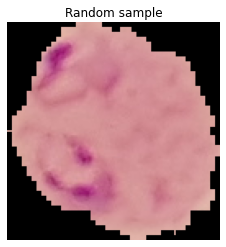

In [31]:
import random
list_directory=["uninfected","parasitized"]
random_directory=(random.choice(list_directory))
random_image= imread(train_path+
                 '/'+random_directory+'/'+
                 os.listdir(train_path+'/'+random_directory)[random.randint(0,(len(os.listdir(train_path+'/'+random_directory+'/'))))])
plt.title("Random sample")
plt.axis("off")
plt.imshow(random_image)
plt.show()

The most frequent dimension(row):130
The most frequent dimension(col):124


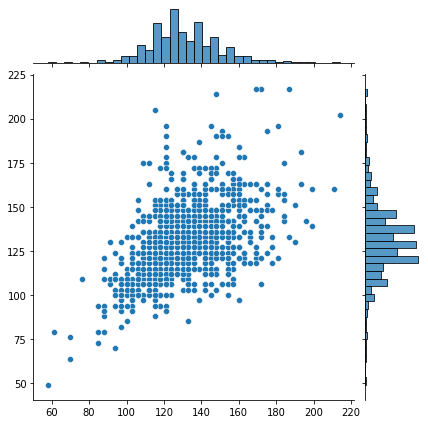


Therefore, let us initialize image shape as: (130, 124, 3)


In [32]:
# Checking the image dimensions
dim1 = []
dim2 = []
for image_filename in os.listdir(test_path+'/uninfected'):
    img = imread(test_path+'/uninfected'+'/'+image_filename)
    d1,d2,colors = img.shape
    dim1.append(d1)
    dim2.append(d2)
w=max(set(dim1),key=dim1.count)
h=max(set(dim2),key=dim2.count)
print("The most frequent dimension(row):"+str(w))
print("The most frequent dimension(col):"+str(h))
sns.jointplot(x=dim1,y=dim2)
plt.show()
print("\nTherefore, let us initialize image shape as: "+str((w,h,3)))
image_shape=(w,h,3)

In [33]:
image_gen = ImageDataGenerator(rotation_range=30, # rotate the image 2\30 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 5%
                               height_shift_range=0.10, # Shift the pic height by a max of 5%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

In [34]:
image_gen.flow_from_directory(train_path)

Found 24958 images belonging to 2 classes.


In [35]:
image_gen.flow_from_directory(test_path)

Found 2600 images belonging to 2 classes.


In [36]:
batch_size = 16
train_image_gen = image_gen.flow_from_directory(train_path,
                                               target_size=image_shape[:2],
                                                color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary')
test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary',shuffle=False)

Found 24958 images belonging to 2 classes.
Found 2600 images belonging to 2 classes.


In [37]:
train_image_gen.batch_size

16

In [38]:
len(train_image_gen.classes)

24958

In [39]:
train_image_gen.total_batches_seen

0

In [40]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [41]:
from keras.callbacks import ModelCheckpoint
filepath = "/content/drive/MyDrive/Colab Notebooks/saved-model-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, save_best_only=False)

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Dense
option=int(input("Do you want to \n1)Create a model and train it.\n2)Use a trained model\n"))
option_valid=False
while not option_valid:
  if(option==1)or(option==2):
    option_valid=True
  else:
    print("Wrong choice!!") 
    option=int(input("Try again"))

Do you want to 
1)Create a model and train it.
2)Use a trained model
2


In [45]:
if option==1:
  model=Sequential()
  model.add(layers.Input(shape= image_shape))
  model.add(Conv2D(128,kernel_size=(5,5),activation='relu'))
  model.add(layers.MaxPool2D())
  model.add(Conv2D(64,kernel_size=(5,5),activation='relu'))
  model.add(layers.MaxPool2D())
  model.add(layers.Flatten())
  model.add(Dense(64,activation='relu'))
  model.add(Dense(32,activation='relu'))
  model.add(Dense(16,activation='relu'))
  model.add(Dense(1,activation='sigmoid'))
  model.compile(optimizer="adam",loss="binary_crossentropy",metrics="accuracy")

  model.summary()

  results = model.fit(train_image_gen,epochs=5,validation_data=test_image_gen,callbacks=checkpoint,verbose=1)
  losses = pd.DataFrame(model.history.history)
  losses[['loss','val_loss']].plot()

elif option==2:
  list_models=[]
  for file in (os.listdir("/content/drive/MyDrive/Colab Notebooks/")):
    if file[-5:] == ".hdf5" or file[-3:]==".h5":
      list_models.append(file)
  print("Choose from one of the models:")
  ind=0;
  for model_ in list_models:
    print("{}-{}".format(ind,model_))
    ind+=1
  choice=int(input("Choice:"))
  try:
    model=models.load_model("/content/drive/MyDrive/Colab Notebooks/"+str(list_models[choice]))
  except:
    print("Couldn't load model!")

Choose from one of the models:
0-cell_model.h5
1-saved-model-01-0.51.hdf5
2-saved-model-02-0.50.hdf5
3-saved-model-01-0.52.hdf5
4-saved-model-02-0.60.hdf5
5-saved-model-03-0.82.hdf5
6-saved-model-04-0.93.hdf5
7-saved-model-05-0.94.hdf5
Choice:5


In [46]:
model.metrics_names

['loss', 'accuracy']

In [47]:
model.evaluate(test_image_gen)

163/163 [==============================] - 105s 640ms/step - loss: 0.3982 - accuracy: 0.8231


[0.398197740316391, 0.8230769038200378]

In [48]:
pred_probabilities = model.predict(test_image_gen)

In [49]:
test_image_gen.classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [50]:
predictions = pred_probabilities > 0.5

In [51]:
print(classification_report(test_image_gen.classes,predictions))

              precision    recall  f1-score   support

           0       0.83      0.79      0.81      1300
           1       0.80      0.84      0.82      1300

    accuracy                           0.82      2600
   macro avg       0.82      0.82      0.82      2600
weighted avg       0.82      0.82      0.82      2600



In [52]:
confusion_matrix(test_image_gen.classes,predictions)

array([[1032,  268],
       [ 205, 1095]])

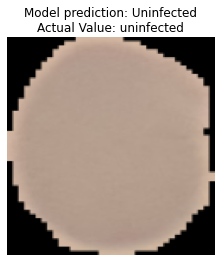

In [61]:
import random
import tensorflow as tf
list_dir=["uninfected","parasitized"]
dir_=(random.choice(list_dir))
para_img= imread(train_path+
                 '/'+dir_+'/'+
                 os.listdir(train_path+'/'+dir_)[random.randint(0,10000)])
img  = tf.convert_to_tensor(np.asarray(para_img))
img = tf.image.resize(img,(w,h))
img=img.numpy()
pred=bool(model.predict(img.reshape(1,w,h,3))<0.5 )
plt.title("Model prediction: "+("Parasitized" if pred  else "Uninfected")+"\nActual Value: "+str(dir_))
plt.axis("off")
plt.imshow(img)
plt.show()